In [1]:
from bs4 import BeautifulSoup
import requests
import time
import csv
from tqdm import tqdm
from textblob import TextBlob
from transformers import pipeline
import spacy
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import re

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Définir les en-têtes HTTP pour éviter d'être bloqué
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
}

# Fonction pour scraper une page et récupérer tous les articles
def scrape_all_page(url):
    all_articles = []  # Liste de tous les articles
    seen_articles = set()  # Ensemble pour garder trace des articles déjà ajoutés

    try:
        # Envoyer une requête HTTP pour obtenir la page
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Trouver tous les articles dans les balises <div class="thread">
            articles = soup.find_all("div", class_="thread")
            
            for article in articles:
                # Extraire le titre
                title_element = article.find("h3", class_="teaser__title")
                title_text = title_element.get_text(strip=True) if title_element else "Titre non disponible"
                
                # Extraire l'URL de l'article
                link_element = article.find("a", class_="teaser__link")
                article_url = link_element["href"] if link_element else None
                if article_url and not article_url.startswith("http"):
                    article_url = f"https://www.lemonde.fr{article_url}"  # Construire l'URL complète si nécessaire
                
                # Extraire la description
                description_element = article.find("p", class_="teaser__desc")
                description_text = description_element.get_text(strip=True) if description_element else "Description non disponible"
                
                # Ajouter l'article à la liste si non déjà vu
                if article_url and article_url not in seen_articles:
                    all_articles.append([title_text, description_text, article_url])
                    seen_articles.add(article_url)

            return all_articles

        else:
            print(f"Erreur HTTP {response.status_code} lors de l'accès à {url}")
            return []

    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return []

# Exemple d'utilisation
url_1 = "https://www.lemonde.fr/agriculture/"
url_2 = "https://www.lemonde.fr/agriculture/2"
articles = scrape_all_page(url_1)
articles += scrape_all_page(url_2)

In [3]:
def extract_date_from_url(url):
    """
    Extrait la date au format YYYY/MM/DD d'une URL de l'article.
    """
    # Expression régulière pour extraire la date au format YYYY/MM/DD
    date_pattern = r'(\d{4})/(\d{2})/(\d{2})'
    match = re.search(date_pattern, url)
    
    if match:
        # Retourner la date au format YYYY-MM-DD
        return f"{match.group(1)}-{match.group(2)}-{match.group(3)}"
    else:
        return None  # Si aucune date n'est trouvée

In [4]:
# Fonction pour extraire les informations d'un article
def fetch_article_details(article_data, headers):
    title, summary, url = article_data
    try:
        # Faire la requête HTTP
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extraire le titre
            title_tag = soup.find('h1', class_='article__title')
            title = title_tag.get_text(strip=True) if title_tag else "Titre non trouvé"

            # Extraire la description (résumé) depuis la balise <p class="article__desc">
            summary_tag = soup.find('p', class_='article__desc')
            summary = summary_tag.get_text(strip=True) if summary_tag else "Résumé non trouvé"

            # Extraire la date de publication depuis la section 'meta__date-reading'
            date = extract_date_from_url(url)

            # Extraire uniquement le premier paragraphe à partir de la classe 'article__paragraph'
            first_paragraph_tag = soup.find('p', class_='article__paragraph')
            first_paragraph = first_paragraph_tag.get_text(strip=True) if first_paragraph_tag else "Premier paragraphe non trouvé"

            return {
                "Title": title,
                "Summary": summary,
                "Date": date,
                "First_Paragraph": first_paragraph
            }
        else:
            print(f"Erreur HTTP {response.status_code} pour {url}")
            return None
    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return None


In [5]:
# Liste pour stocker les résultats détaillés de chaque article
detailed_articles = []

# Boucle pour appliquer la fonction à chaque article
for article_data in articles:
    article_details = fetch_article_details(article_data, headers)
    
    # Si les détails de l'article ont été extraits avec succès, ajoutez-les à la liste
    if article_details:
        detailed_articles.append(article_details)


In [6]:
# Fonction pour filtrer les articles contenant le mot "bio" et inclure une liste des textes où il a été trouvé
def filter_bio_articles(detailed_articles):
    bio_articles = []
    
    # Parcourir tous les articles de detailed_articles
    for article in detailed_articles:
        # Initialiser une liste pour stocker les textes où "bio" est trouvé
        found_in_texts = []
        
        # Vérifier si le mot "bio" est présent dans le titre
        if "bio" in article['Title'].lower():
            found_in_texts.append(article['Title'])
        
        # Vérifier si le mot "bio" est présent dans la description (résumé)
        if "bio" in article['Summary'].lower():
            found_in_texts.append(article['Summary'])
        
        # Vérifier si le mot "bio" est présent dans le premier paragraphe
        if "bio" in article['First_Paragraph'].lower():
            found_in_texts.append(article['First_Paragraph'])
        
        # Si le mot "bio" est trouvé dans l'un des champs, ajouter l'article à la liste bio_articles
        if found_in_texts:
            article["Found_in"] = found_in_texts  # Ajouter les textes où "bio" a été trouvé sous forme de liste
            bio_articles.append(article)
    
    return bio_articles

# Appliquer la fonction pour filtrer les articles contenant le mot "bio"
bio_filtered_articles = filter_bio_articles(detailed_articles)


In [7]:
# Charger le modèle spaCy pour le français
nlp = spacy.load("fr_core_news_sm")

# Fonction pour filtrer les phrases contenant "bio"
def filter_sentences_containing_bio(article):
    # Extraire la liste de textes de la clé "Found_in"
    filtered_found_in = []
    
    # Parcours de toutes les phrases dans "Found_in"
    for text in article['Found_in']:
        # Traitement du texte avec spaCy pour obtenir un document linguistique
        doc = nlp(text)
        
        # Vérifier si le mot "bio" (ou variantes) est dans le texte
        # En convertissant le texte en minuscules pour la recherche
        if "bio" in text.lower():
            filtered_found_in.append(text)
    
    # Mettre à jour la clé "Found_in" de l'article avec les phrases filtrées
    article['Found_in'] = filtered_found_in
    
    return article

# Appliquer la fonction sur l'exemple d'article
for article in bio_filtered_articles:
    article = filter_sentences_containing_bio(article)

# Afficher les résultats filtrés
print(len(bio_filtered_articles))

16


In [8]:

# Charger explicitement le modèle de sentiment d'Hugging Face
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment_bio_with_model(text):
    """
    Utilise un modèle open-source pour analyser le sentiment d'un texte concernant le bio.
    Le score sera entre 0 (négatif) et 1 (positif).
    """
    # Utiliser le modèle de sentiment pour prédire le sentiment
    result = sentiment_analyzer(text)

    # Le modèle retourne une liste avec un dictionnaire contenant les labels et scores
    sentiment = result[0]
    
    # Convertir le label en score : 'LABEL_1' est positif, 'LABEL_0' est négatif
    if sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    else:
        return 1 - sentiment['score']  # Retourner un score entre 0 et 1 pour un sentiment négatif


Device set to use cpu


In [9]:
# Fonction pour appliquer l'analyse de sentiment à chaque élément dans la liste de dictionnaires
def add_sentiment_score_to_list_of_dicts(data):
    """
    Applique l'analyse de sentiment sur chaque phrase de la clé 'Found_in' dans une liste de dictionnaires
    et ajoute la moyenne des scores de sentiment à chaque dictionnaire.
    """
    for entry in data:
        # Extraire les phrases de la clé 'Found_in'
        sentences = entry['Found_in']
        
        # Appliquer l'analyse de sentiment à chaque phrase
        sentiment_scores = [analyze_sentiment_bio_with_model(sentence) for sentence in sentences]
        
        # Calculer la moyenne des scores
        average_score = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        # Ajouter la moyenne au dictionnaire
        entry['Average_Sentiment_Score'] = average_score
    
    return data

# Appliquer la fonction pour ajouter la moyenne des scores de sentiment à chaque dictionnaire
data_with_scores = add_sentiment_score_to_list_of_dicts(bio_filtered_articles)


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.colors as mcolors

def plot_sentiment_score_by_date(data):
    """
    Génère un graphique avec une barre pour chaque mois, colorée en fonction du score moyen de sentiment.
    Les mois sont affichés sous chaque barre.

    :param data: Liste de dictionnaires contenant les articles avec les scores de sentiment et les dates.
    """
    # Initialisation des dictionnaires pour compter les articles et calculer la somme des scores par mois
    articles_per_month = {}
    scores_per_month = {}

    for entry in data:
        date_str = entry['Date']
        score = entry['Average_Sentiment_Score']  # Score de sentiment
        
        try:
            # Essayer de convertir la date au format 'YYYY-MM-DD'
            date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            
            # Formater la date pour obtenir le mois et l'année (format 'YYYY-MM')
            month_year = date_obj.strftime('%Y-%m')
            
            # Incrémenter le compteur pour le mois et ajouter le score pour le calcul du score moyen
            if month_year not in articles_per_month:
                articles_per_month[month_year] = 0
                scores_per_month[month_year] = 0.0
            articles_per_month[month_year] += 1
            scores_per_month[month_year] += score
        except ValueError as e:
            print(f"Erreur de format de date pour '{entry['Title']}': {e}")
            continue

    # Calculer le score moyen par mois
    average_scores = {month: scores_per_month[month] / articles_per_month[month] for month in articles_per_month}

    # Créer une liste de tous les mois de l'année (en format YYYY-MM)
    all_months = pd.date_range(start=min(pd.to_datetime(list(articles_per_month.keys()))), 
                               end=max(pd.to_datetime(list(articles_per_month.keys()))), 
                               freq='MS').strftime('%Y-%m').tolist()

    # Liste des mois avec ou sans articles
    month_labels = []
    month_counts = []
    month_scores = []
    
    # Ajouter des mois manquants (ceux sans articles)
    for month in all_months:
        month_labels.append(month)
        month_counts.append(articles_per_month.get(month, 0))
        month_scores.append(average_scores.get(month, 0))

    # Créer un DataFrame avec les mois, le nombre d'articles et le score moyen
    df = pd.DataFrame({
        'Month': month_labels,
        'Article_Count': month_counts,
        'Average_Score': month_scores
    })

    # Créer une échelle de couleurs pour les scores (de rouge à vert)
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.colormaps['RdYlGn']  # Palette de couleurs allant de rouge (0) à vert (1)
    
    # Tracer les données
    fig, ax = plt.subplots(figsize=(12, 7))
    bar_colors = [cmap(norm(score)) for score in df['Average_Score']]  # Couleur des barres en fonction du score moyen
    bars = ax.bar(df['Month'], df['Article_Count'], color=bar_colors)

    # Ajouter des labels et un titre
    ax.set_xlabel('Mois de Publication', fontsize=12)
    ax.set_ylabel('Nombre d\'Articles', fontsize=12)
    ax.set_title('Nombre d\'Articles par Mois avec Scores Moyens', fontsize=14)

    # Rotation des labels de l'axe X pour une meilleure lisibilité
    plt.xticks(rotation=45, fontsize=10)

    # Définir les ticks de l'axe X (positionner les mois)
    tick_positions = range(len(df['Month']))
    ax.set_xticks(tick_positions)

    # Mettre l'année une seule fois pour chaque année
    ax.set_xticklabels([label if i == 0 or label[:4] != df['Month'][i-1][:4] else label[5:] for i, label in enumerate(df['Month'])])

    # Ajouter une grille
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajouter une légende de couleur (colorbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Nécessaire pour afficher la légende
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
    cbar.set_label('Score Moyen')

    # Ajustement des marges
    plt.tight_layout()

    # Afficher le graphique
    plt.show()


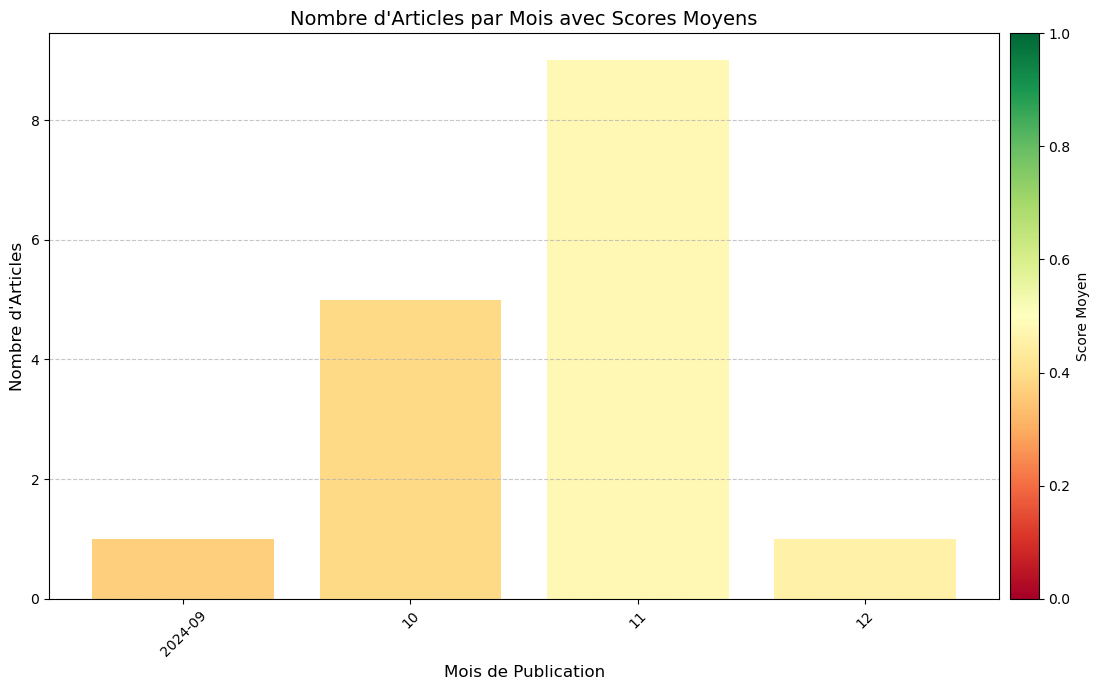

In [11]:
plot_sentiment_score_by_date(bio_filtered_articles)

In [12]:
# Définir les en-têtes HTTP pour éviter d'être bloqué
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
}

# Fonction pour scraper une page de recherche et récupérer les articles
def scrape_archive_page(url):
    all_articles = []  # Liste de tous les articles
    seen_articles = set()  # Ensemble pour garder trace des articles déjà ajoutés

    try:
        # Envoyer une requête HTTP pour obtenir la page
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Trouver tous les articles dans les balises <a class="teaser__link">
            articles = soup.find_all("a", class_="teaser__link")
            
            for article in articles:
                # Extraire le titre
                title_element = article.find("h3", class_="teaser__title")
                title_text = title_element.get_text(strip=True) if title_element else "Titre non disponible"
                
                # Extraire l'URL de l'article
                article_url = article["href"] if article else None
                if article_url and not article_url.startswith("http"):
                    article_url = f"https://www.lemonde.fr{article_url}"  # Construire l'URL complète si nécessaire
                
                # Extraire la description
                description_element = article.find("p", class_="teaser__desc")
                description_text = description_element.get_text(strip=True) if description_element else "Description non disponible"
                
                # Ajouter l'article à la liste si non déjà vu
                if article_url and article_url not in seen_articles:
                    all_articles.append([title_text, description_text, article_url])
                    seen_articles.add(article_url)

            return all_articles

        else:
            print(f"Erreur HTTP {response.status_code} lors de l'accès à {url}")
            return []

    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return []

# Fonction pour scraper plusieurs pages de résultats
def scrape_multiple_pages(base_url, total_pages=250):
    all_articles = []

    for page_num in range(1, total_pages + 1):
        # Construire l'URL de la page actuelle en modifiant le paramètre "page"
        url = f"{base_url}&page={page_num}"
        print(f"Scraping page {page_num}: {url}")
        articles = scrape_archive_page(url)
        all_articles.extend(articles)

    return all_articles

# URL de base de la recherche
base_url = "https://www.lemonde.fr/recherche/?search_keywords=agriculture&start_at=19/12/1944&end_at=22/12/2024&search_sort=relevance_desc"

# Scraper les 250 pages
articles = scrape_multiple_pages(base_url)

# Exemple d'affichage des 5 premiers articles récupérés
for article in articles[:5]:
    print(article)


Scraping page 1: https://www.lemonde.fr/recherche/?search_keywords=agriculture&start_at=19/12/1944&end_at=22/12/2024&search_sort=relevance_desc&page=1
Scraping page 2: https://www.lemonde.fr/recherche/?search_keywords=agriculture&start_at=19/12/1944&end_at=22/12/2024&search_sort=relevance_desc&page=2
Scraping page 3: https://www.lemonde.fr/recherche/?search_keywords=agriculture&start_at=19/12/1944&end_at=22/12/2024&search_sort=relevance_desc&page=3
Scraping page 4: https://www.lemonde.fr/recherche/?search_keywords=agriculture&start_at=19/12/1944&end_at=22/12/2024&search_sort=relevance_desc&page=4
Scraping page 5: https://www.lemonde.fr/recherche/?search_keywords=agriculture&start_at=19/12/1944&end_at=22/12/2024&search_sort=relevance_desc&page=5
Scraping page 6: https://www.lemonde.fr/recherche/?search_keywords=agriculture&start_at=19/12/1944&end_at=22/12/2024&search_sort=relevance_desc&page=6
Scraping page 7: https://www.lemonde.fr/recherche/?search_keywords=agriculture&start_at=19/12/

In [13]:
len(articles_archive)

NameError: name 'articles_archive' is not defined